# Bibliotecas

In [1]:
import math
import os
import re
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from datetime import timedelta
from sklearn.cluster import KMeans
from random import randint
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support , roc_auc_score, auc, precision_score
from timeit import default_timer as timer

%run ./base_functions.ipynb

pd.options.mode.chained_assignment = None # desabilita warnings de SettingWithCopyWarning
plt.rcParams.update({'figure.max_open_warning': 0}) # desabilita warning para plot de mais de 20 figuras

In [2]:
# Caminho no qual as imagens geradas serão salvas quando exportadas
saving_path = r"C:\Users\anaso\Desktop\workspace\doutorado\imagens"

# Funções

In [3]:
class PCA():
   
    # ---------------------------------------------------------------------------
    # Método construtor
    # Função que será chamada toda vez que um objeto PCA for inicializado
    # O modelo selecionará quantos PCs forem necessários para cumprir o % de variabilidade explicada especificado em a

    def __init__ (self, a=0.9):

        # se 0<=a<1,  'a' indica a fraçao de variancia explicada desejada
        # se a>=1,    'a' indica o numero de componentes desejado
        self.a = a
   
    # ---------------------------------------------------------------------------
    # Função para treino do modelo
    # X são os dados de treino
    
    def fit(self, X, conf_Q=0.99, conf_T2=0.99, plot=True):
    
        # guardando médias e desvios-padrão do treino (de cada coluna)
        self.mu_train = X.mean(axis=0)
        self.std_train = X.std(axis=0)        
       
        # normalizando dados de treino
        X = np.array(((X - self.mu_train)/self.std_train))
       
        # calculando a matriz de covariâncias dos dados
        Cx = np.cov(X, rowvar=False)
        
        # aplicando decomposição em autovalores e autovetores
        self.L, self.P = np.linalg.eig(Cx)
        
        # frações da variância explicada
        fv = self.L/np.sum(self.L)
        
        # frações da variância explicada acumuladas
        fva = np.cumsum(self.L)/sum(self.L)
       
        # definindo número de componentes
        if (self.a>0 and self.a<1):
            self.a = np.where(fva>self.a)[0][0]+1 
            
        # calculando limites de detecção

        # limite da estatística T^2
        from scipy.stats import f
        F = f.ppf(conf_T2, self.a, X.shape[0]-self.a)
        self.T2_lim = ((self.a*(X.shape[0]**2-1))/(X.shape[0]*(X.shape[0]-self.a)))*F
        print("T2_lim: ", self.T2_lim)
        
        # limite da estatística Q
        theta = [np.sum(self.L[self.a:]**(i)) for i in (1,2,3)]
        ho = 1-((2*theta[0]*theta[2])/(3*(theta[1]**2)))
        from scipy.stats import norm
        nalpha = norm.ppf(conf_Q)
        self.Q_lim = (theta[0]*(((nalpha*np.sqrt(2*theta[1]*ho**2))/theta[0])+1+
                                ((theta[1]*ho*(ho-1))/theta[0]**2))**(1/ho))
        print("Q_lim: ", self.Q_lim)
        
        # plotando variâncias explicadas
        if plot:
            fig, ax = plt.subplots()
            ax.bar(np.arange(len(fv)),fv)
            ax.plot(np.arange(len(fv)),fva)
            ax.set_xlabel('Número de componentes')
            ax.set_ylabel('Variância dos dados')
            ax.set_title('PCA - Variância Explicada');

    # ---------------------------------------------------------------------------
    # Função para teste do modelo
            
    def predict(self, X):
            
        # normalizando dados de teste (usando os parâmetros do treino!)
        X = np.array((X - self.mu_train)/self.std_train)

        # calculando estatística T^2
        T = X@self.P[:,:self.a]
        self.T2 = np.array([T[i,:]@np.linalg.inv(np.diag(self.L[:self.a]))@T[i,:].T for i in range(X.shape[0])])
        
        # calculando estatística Q
        e = X - X@self.P[:,:self.a]@self.P[:,:self.a].T
        self.Q  = np.array([e[i,:]@e[i,:].T for i in range(X.shape[0])])
        
        # calculando contribuições para Q
        self.c = np.absolute(X*e) 
                
    # ---------------------------------------------------------------------------
    # Função para plotar cartas de controle
    
    def plot_control_charts(self, fault = None):
     
        fig, ax = plt.subplots(1,2, figsize=(15,3))
        
        ax[0].semilogy(self.T2,'.')
        ax[0].axhline(self.T2_lim,ls='--',c='r');
        ax[0].set_title('Carta de Controle $T^2$')
        
        ax[1].semilogy(self.Q,'.')
        ax[1].axhline(self.Q_lim,ls='--',c='r')
        ax[1].set_title('Carta de Controle Q')
 
        if fault is not None:
            ax[0].axvline(fault, c='w')
            ax[1].axvline(fault, c='w')

    # ---------------------------------------------------------------------------
    # Função para plotar mapas de contribuição
            
    def plot_contributions(self, fault=None, index=None, columns=None):

        fig, ax = plt.subplots(figsize=(20, 6))
        
        c = pd.DataFrame(self.c, index=index, columns=columns)
    
        sns.heatmap(c, ax=ax, yticklabels=int(self.c.shape[0]/10), cmap = plt.cm.Blues)
        
        ax.set_title('Contribuições parciais para Q')
        
        if fault is not None:
            ax.axhline(y=c.index[fault], ls='--', c='k')

In [4]:
def print_overview(data):
    
    """
    Retorna algumas informações gerais sobre o banco de dados, como existência de nulos e duplicatas, dentre outros.
    """
    
    # Shape do banco
    print("Shape do banco: ", data.shape)
    
    # Alguma linha com todos os valores zerados?
    zero_rows = data.index[(data==0).all(axis=1)].tolist()
    print("\nQuantidade de linhas zeradas: ", len(zero_rows))
    
    # Existem nulos?
    print("Quantidade de nulos no banco: ", data.isnull().sum().sum())
    
    # Há duplicatas baseado no timestamp?
    qtd_duplis = len(data[data.duplicated(['timestamp'])])
    if (qtd_duplis > 0):
        print("Quantidade de duplicatas: ", qtd_duplis)
#         print(data[data.duplicated(['timestamp'])])
    else:
        print("\nNão há registros duplicados.")
    
    print()
    
    # Alguma coluna possui um único valor constante?
    single_values_columns = []
    for col in (data.columns):
        unique_values = data[col].nunique()
        if (unique_values == 1):
            single_values_columns.append(col)
    if len(single_values_columns) > 0:
        print("Existem " + str(len(single_values_columns)) + " colunas constantes. São elas: " + str(single_values_columns))
    else:
        print("Não há colunas constantes.")
    
    # Alguma linha inteiramente zerada?
    data_sem_dt = data.drop(['timestamp'], 1)
    zero_rows = data_sem_dt.index[(data_sem_dt == 0).all(axis=1)].tolist()
    if len(zero_rows) > 0:
        print("Existem " + str(len(zero_rows)) + " linhas inteiramente zeradas.")
    else:
        print("Não há linhas inteiramente zeradas.")
    
    # Alguma linha com todas as colunas NaN?
    nan_rows = data.index[(data == float('nan')).all(axis=1)].tolist()
    if len(nan_rows) > 0:
        print("Existem " + str(len(nan_rows)) + " instâncias sem registro.")
    else:
        print("Não há linhas inteiramente sem registro (nan).")

In [5]:
def fault_cluster(dataset, fault_id, days_to_count, clusters):
    
    init_nota = fault_log.loc[fault_log['ID'] == fault_id]['InicioAvar'].reset_index().iloc[0,1]
    pre_falha = init_nota - timedelta(days=days_to_count)

    fim_ordem = fault_log.loc[fault_log['ID'] == fault_id]['Dt.real fim'].reset_index().iloc[0,1]
    fim_ordem = datetime.datetime.combine(fim_ordem, datetime.time.max) # define a última hora possível (23:59)
    pos_manut = fim_ordem + timedelta(days=days_to_count) 

    fault_data = dataset.loc[(dataset['timestamp'] >= pre_falha) & (dataset['timestamp'] <= pos_manut)]

    fault_data_scaled = preprocessing.scale(fault_data.drop(['timestamp','rotulos_multi','rotulos_bin'], 1))
    
    kmeans = KMeans(n_clusters=clusters, max_iter=1000, random_state=0).fit(fault_data_scaled)
    x_clustered = kmeans.fit_predict(fault_data_scaled)
    
    return x_clustered, fault_data, init_nota, fim_ordem

In [6]:
def plot_cluster(fault_data, x_clustered, var, init_nota, fim_ordem):
    
    fault_data['clusters'] = x_clustered
    min_lim = fault_data[var].min()-500
    max_lim = fault_data[var].max()+500
    
    n_clusters = len(np.unique(x_clustered))
    colors_list = ['red', 'blue', 'green']
    count = 0
    colors_dict = {}

    for i in range(n_clusters):
        colors_dict[i] = colors_list[i]
        count+=1
    
    label_color = [colors_dict[l] for l in x_clustered]
    
    plt.figure(figsize=(15,3))
    plt.plot(fault_data['timestamp'], fault_data[var], marker='o', linestyle='None')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.show()

    plt.figure(figsize=(15,3))
    plt.plot(fault_data.query("clusters == 0")['timestamp'], fault_data.query("clusters == 0")[var], \
             colors_dict[0], marker='o', linestyle='None', label='CLUSTER 01')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(15,3))
    plt.plot(fault_data.query("clusters == 1")['timestamp'], fault_data.query("clusters == 1")[var], \
             colors_dict[1], marker='o', linestyle='None', label='CLUSTER 02')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.legend(loc='upper left')
    plt.show()

    if (n_clusters == 3):
        plt.figure(figsize=(15,3))
        plt.plot(fault_data.query("clusters == 2")['timestamp'], fault_data.query("clusters == 2")[var], colors_dict[2], marker='o', linestyle='None')
        plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
        plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
        plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
        plt.ylim([min_lim, max_lim])
        plt.show()

# Leitura dos arquivos

In [7]:
data = pd.read_csv(r"D:\Caso 2 - Bomba Centrífuga\final_data.csv", sep=';')
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [8]:
fault_log = pd.read_excel("D:\Caso 2 - Bomba Centrífuga\Bancos tratados\Falhas_Bomba_final_v0.xlsx")

fault_log['InicioAvar'] = pd.to_datetime(fault_log['InicioAvar'])
fault_log['Dt.real fim'] = pd.to_datetime(fault_log['Dt.real fim'])

# Remoção das falhas não marcadas - longas ou contidas em outras falhas
fault_log = fault_log.dropna(subset=['Filtro'])

In [9]:
# Informações gerais sobre o banco

print_overview(data)

Shape do banco:  (1435326, 26)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  0

Não há registros duplicados.

Não há colunas constantes.
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


# Banco 1 - Rótulos via OMs

In [10]:
labeled_data = data.copy()

labeled_data['rotulos_multi'] = np.zeros(())
labeled_data['rotulos_bin'] = np.zeros(())

In [11]:
for i in range(len(fault_log)):
    
    ID = fault_log.iloc[i]['ID']
    
    print("\n--------------------------------------------------------------------------------")
    print("Falha ", (ID))

    init_falha = fault_log.iloc[i]['InicioAvar']
    init_falha = datetime.datetime.combine(init_falha, datetime.time.min)

    end_falha = fault_log.iloc[i]['Dt.real fim']
    end_falha = datetime.datetime.combine(end_falha, datetime.time.max)

    df_fault_final = labeled_data.loc[((labeled_data["timestamp"] >= init_falha) & 
                                       (labeled_data["timestamp"] <= end_falha))]
    elapsed_time = end_falha - init_falha

    print("Dias:  ", elapsed_time.days)
    print("Horas: ", divmod(elapsed_time.total_seconds(), 3600)[0])
    print("Instâncias: ", len(df_fault_final))

    if (len(df_fault_final) == 0):
        print("Falha " + str(ID) + " não existe!")
    else:
        labeled_data.loc[
            ((labeled_data["timestamp"] >= init_falha) & (labeled_data["timestamp"] <= end_falha)), 'rotulos_multi'] = ID

        labeled_data.loc[
            ((labeled_data["timestamp"] >= init_falha) & (labeled_data["timestamp"] <= end_falha)), 'rotulos_bin'] = 1

    print("Init falha: ", labeled_data.loc[labeled_data['rotulos_multi'] == ID]['timestamp'].min())
    print("End falha : ", labeled_data.loc[labeled_data['rotulos_multi'] == ID]['timestamp'].max())
    print("\nReal:")
    print("Init falha: ", init_falha)
    print("End falha : ", end_falha)


--------------------------------------------------------------------------------
Falha  1
Dias:   2
Horas:  71.0
Instâncias:  726
Init falha:  2011-05-22 11:54:00
End falha :  2011-05-22 23:59:00

Real:
Init falha:  2011-05-20 00:00:00
End falha :  2011-05-22 23:59:59.999999

--------------------------------------------------------------------------------
Falha  2
Dias:   18
Horas:  455.0
Instâncias:  5717
Init falha:  2011-07-02 00:00:00
End falha :  2011-07-07 18:47:00

Real:
Init falha:  2011-07-02 00:00:00
End falha :  2011-07-20 23:59:59.999999

--------------------------------------------------------------------------------
Falha  4
Dias:   3
Horas:  95.0
Instâncias:  0
Falha 4 não existe!
Init falha:  NaT
End falha :  NaT

Real:
Init falha:  2011-09-03 00:00:00
End falha :  2011-09-06 23:59:59.999999

--------------------------------------------------------------------------------
Falha  5
Dias:   19
Horas:  479.0
Instâncias:  25469
Init falha:  2012-04-12 00:00:00
End falha : 

In [12]:
Counter(labeled_data['rotulos_multi'])

Counter({0.0: 770855,
         1.0: 726,
         2.0: 5717,
         6.0: 232665,
         7.0: 26067,
         8.0: 1351,
         9.0: 14850,
         10.0: 8301,
         11.0: 285146,
         17.0: 2757,
         18.0: 13413,
         19.0: 4,
         20.0: 10656,
         24.0: 34503,
         25.0: 28297,
         27.0: 18})

In [13]:
Counter(labeled_data['rotulos_bin'])

Counter({0.0: 770855, 1.0: 664471})

### K-Means

In [ ]:
x_data = labeled_data.drop(['timestamp','rotulos_multi','rotulos_bin'], axis=1)

In [ ]:
sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(x_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_data)
X_clustered = kmeans.fit_predict(x_data)

In [ ]:
results = labeled_data[['rotulos_bin','rotulos_multi']].copy()
results['clusterNumber'] = X_clustered
results.head()

In [ ]:
Counter(results['clusterNumber'])

In [ ]:
print(results.query("clusterNumber == 0")['rotulos_multi'].unique())
print(results.query("clusterNumber == 1")['rotulos_multi'].unique())

In [ ]:
LABEL_COLOR_MAP = {0 : 'red', 1 : 'blue'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

c1 = 0 
c2 = 1
features = ['VT-321', 'VT-323']
c1feature = features[c1]
c2feature = features[c2]
title = features[c1] + ' x ' + features[c2]

plt.figure(figsize=(8,8))
plt.scatter(x_data.iloc[:, c1], x_data.iloc[:, c2], c=label_color, alpha=0.3) 
plt.xlabel(c1feature, fontsize=18)
plt.ylabel(c2feature, fontsize=18)
plt.suptitle(title, fontsize=20)
# plt.savefig(title + '.jpg')
plt.show()

In [ ]:
x_data_labeled = pd.concat([x_data, results], axis=1)
x_data_labeled.shape

LABEL_COLOR_MAP = {0 : 'red', 1 : 'blue'}
# label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

c1 = 0 
c2 = 1
features = ['VT-321', 'VT-322']
c1feature = features[c1]
c2feature = features[c2]
title = features[c1] + ' x ' + features[c2]

for fault in results.rotulos_multi.unique()[1:]:

    print("\n-----------------------------------------------------------------------------------------------------------")
    print("Falha ", fault)

    data_fault = x_data_labeled[x_data_labeled['rotulos_multi'] == fault].copy()
    print("Clusters: ", data_fault['clusterNumber'].unique())
    label_color = [LABEL_COLOR_MAP[l] for l in data_fault['clusterNumber']]
    
    plt.figure(figsize=(8,8))
    plt.scatter(data_fault.iloc[:, c1], data_fault.iloc[:, c2], c=label_color, alpha=0.3) 
    plt.xlabel(c1feature, fontsize=18)
    plt.ylabel(c2feature, fontsize=18)
    plt.suptitle(title, fontsize=20)
    # plt.savefig(title + '.jpg')
    plt.show()

In [ ]:
for fault in labeled_data.rotulos_multi.unique()[1:]:

    print("\n-----------------------------------------------------------------------------------------------------------")
    print(fault)
    
    x_clustered, fault_data, init_nota, fim_ordem = fault_cluster(labeled_data, fault, 20, 2)
    plot_cluster(fault_data, x_clustered, 'VT-322', init_nota, fim_ordem)

### PCA usando os dados normais apenas do treino

In [14]:
# Considera apenas a op. normal contida no treino
    # Vai até o último ponto de operação normal antes da falha 17
data_normal = labeled_data[:1216608].query("rotulos_multi == 0").copy() 

time_data = data_normal[['timestamp']].copy()
data_normal.drop(['rotulos_bin', 'rotulos_multi', 'timestamp'], 1, inplace=True)

T2_lim:  26.217788760590462
Q_lim:  5.887452406641789

PCs:  12


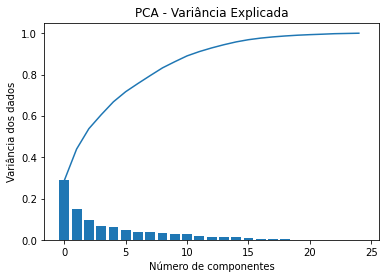

In [15]:
# Todos os trechos de operação normal 
df_train = data_normal.copy()

# Instancia o objeto PCA
pca = PCA(a=0.9)

# Treina o modelo PCA
pca.fit(df_train)

print("\nPCs: ", pca.a)


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(1.0)

T2: 0.19559228650137742
Q: 0.1652892561983471


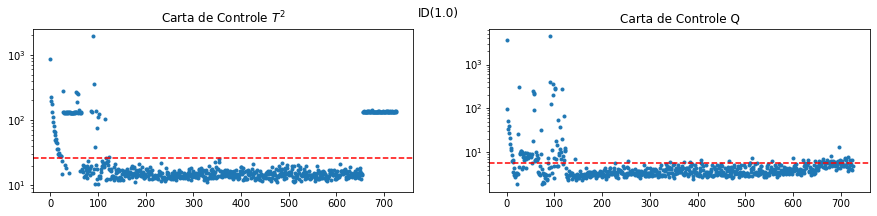

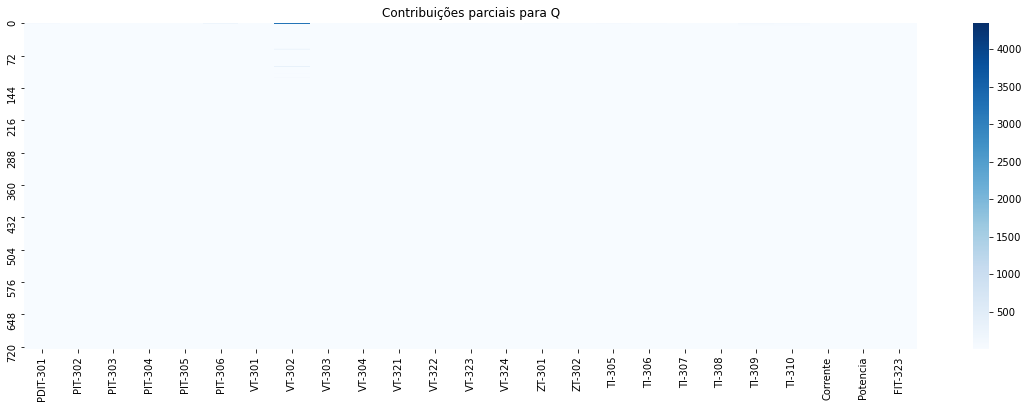


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(2.0)

T2: 0.9662410355081337
Q: 0.9485744271471052


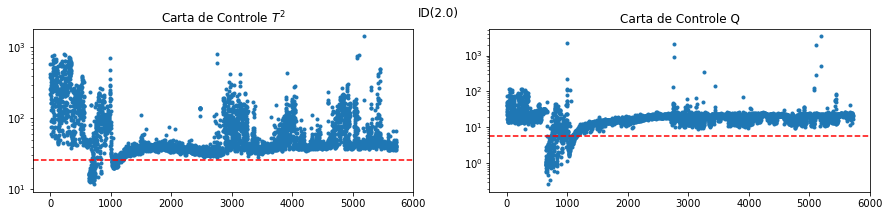

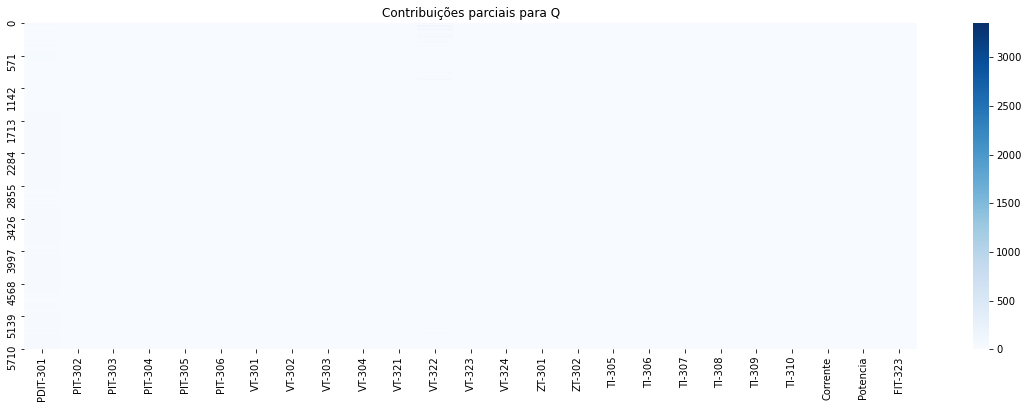


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(6.0)

T2: 0.27081855887219825
Q: 0.45638579072915997


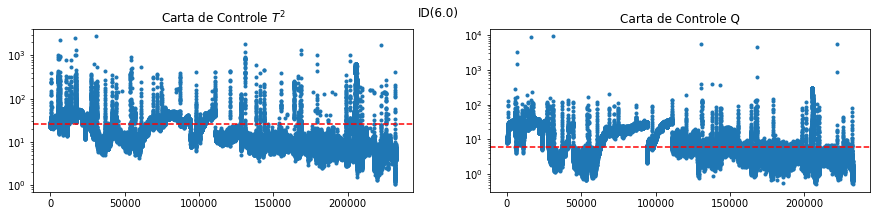

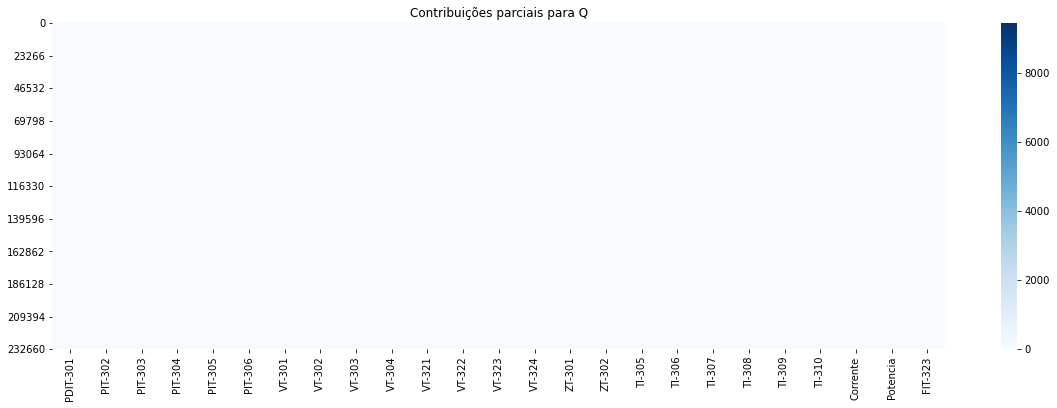


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(7.0)

T2: 0.07062569532358921
Q: 0.01296658610503702


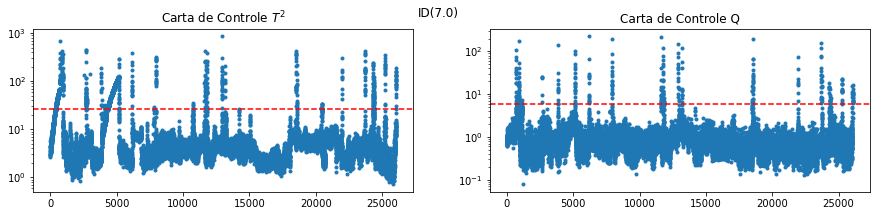

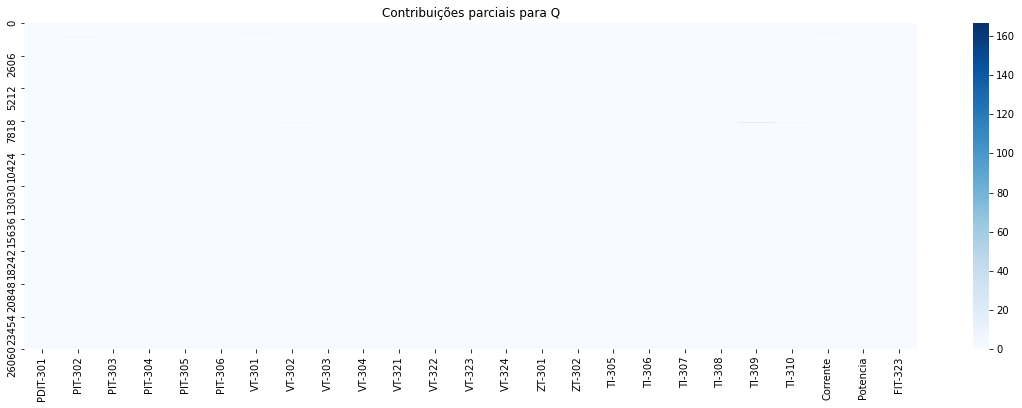


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(8.0)

T2: 0.7105847520355293
Q: 0.7150259067357513


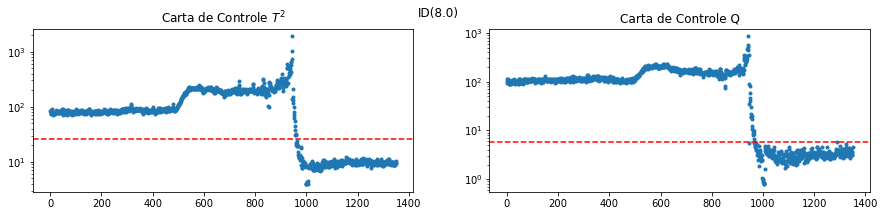

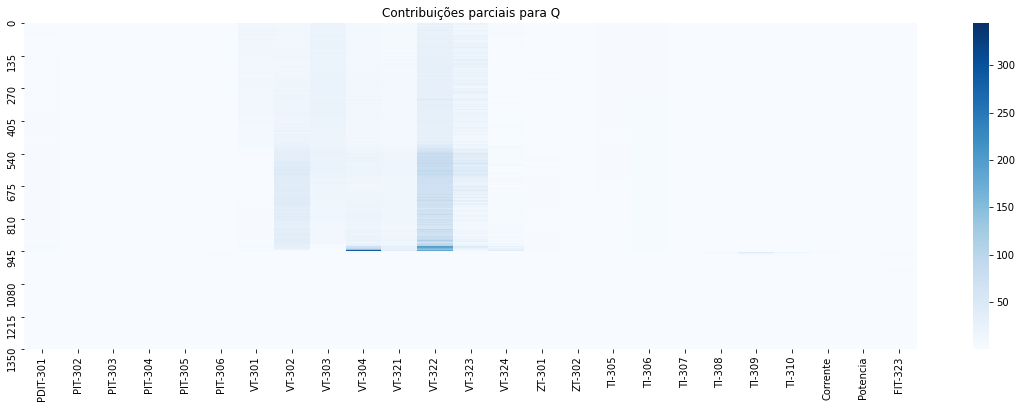


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(9.0)

T2: 0.004915824915824916
Q: 0.0051178451178451176


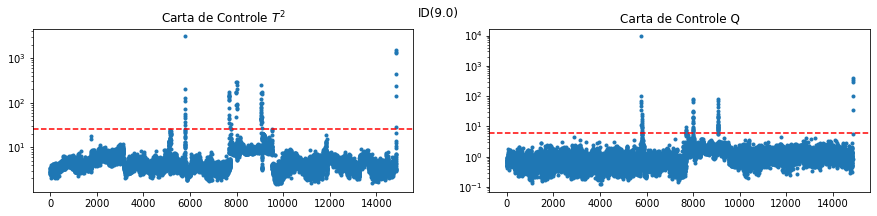

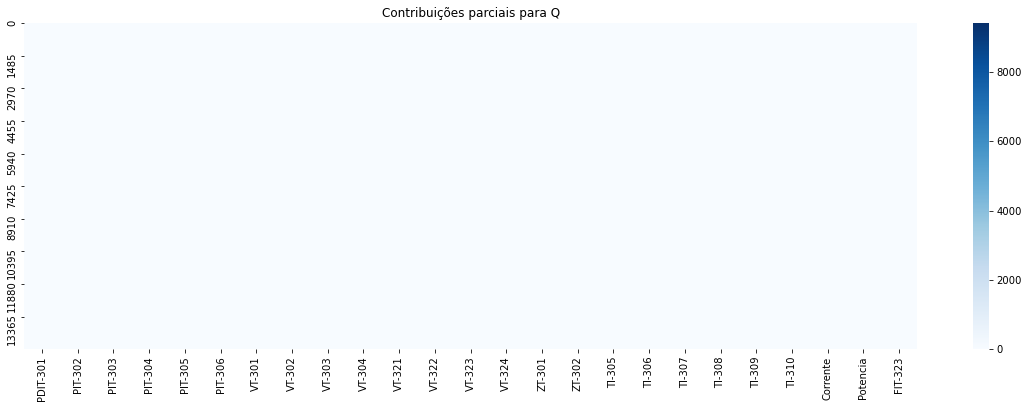


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(10.0)

T2: 0.008673653776653415
Q: 0.02855077701481749


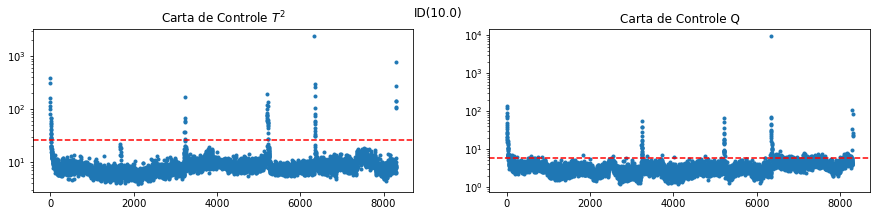

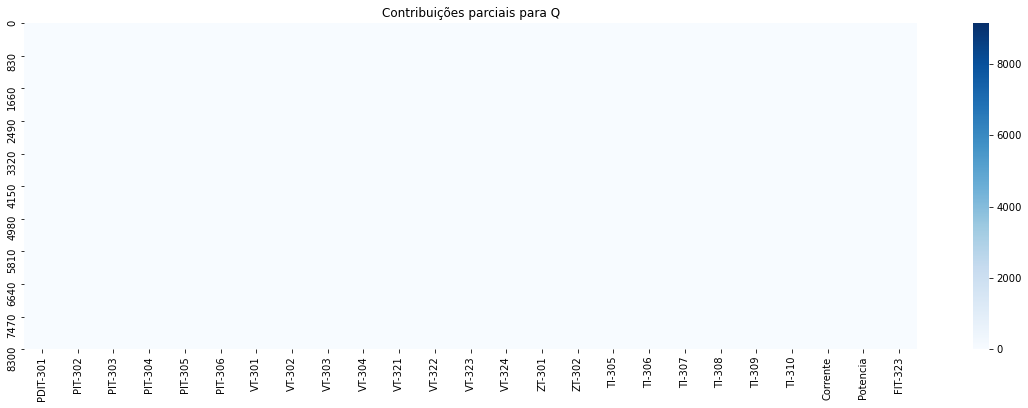


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(11.0)

T2: 0.08355719526137488
Q: 0.6885595449348755


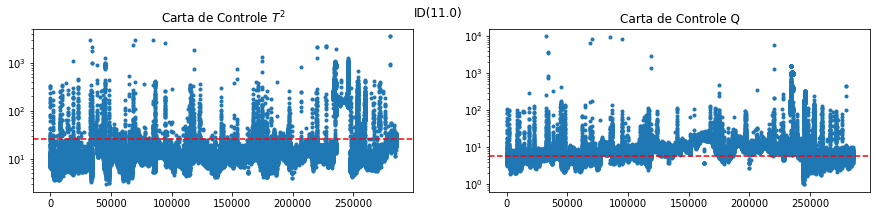

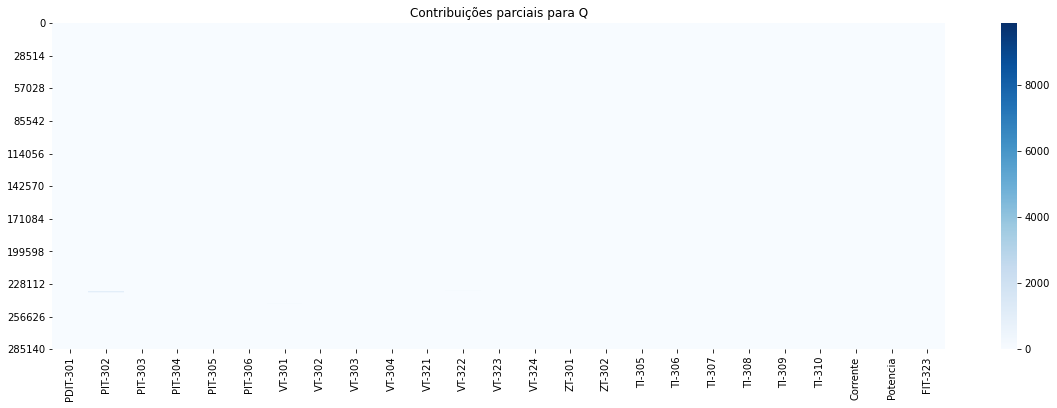


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(17.0)

T2: 0.8647080159593762
Q: 0.6111715632934349


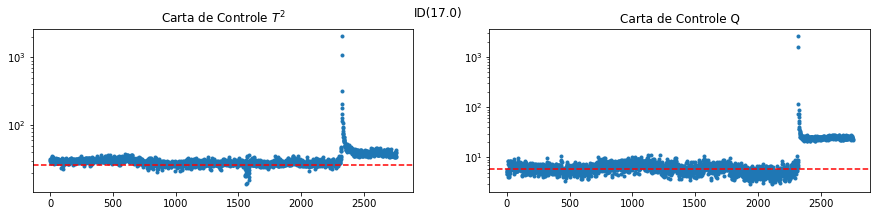

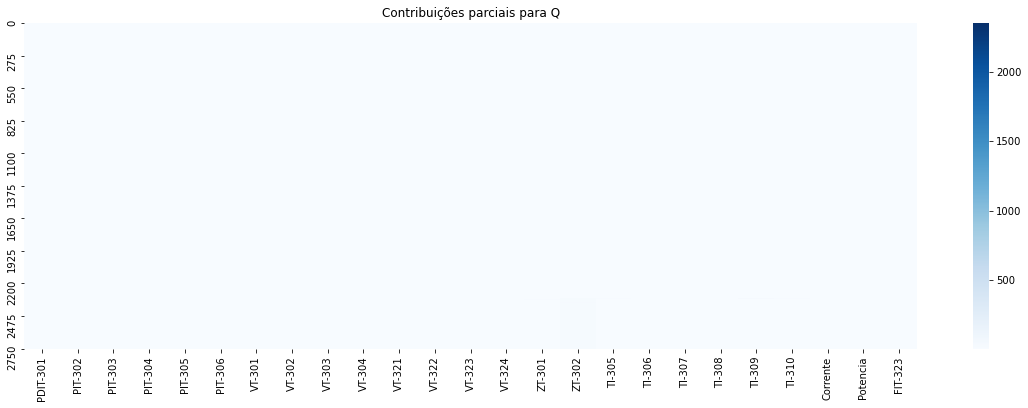


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(18.0)

T2: 0.4790128979348393
Q: 1.0


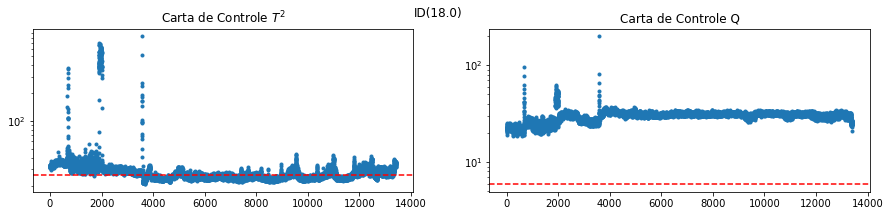

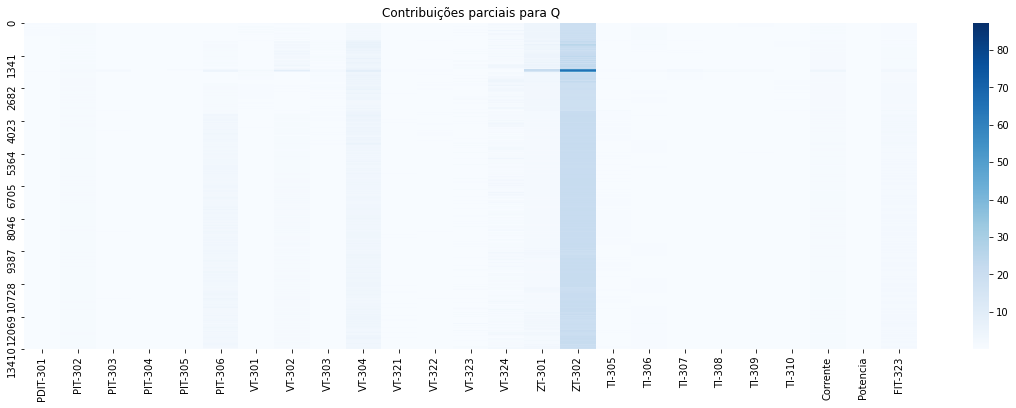


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(19.0)

T2: 1.0
Q: 1.0


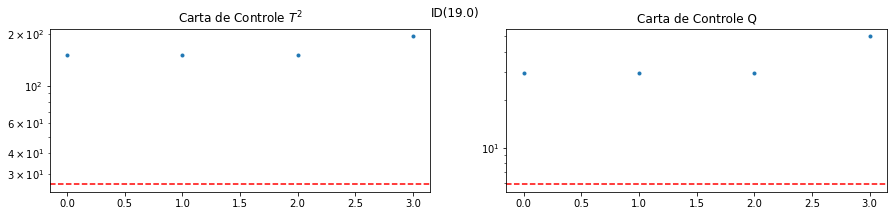

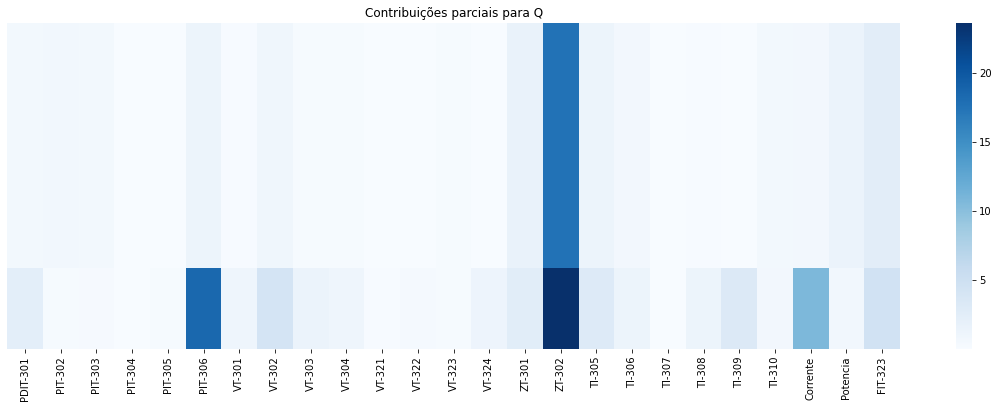


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(20.0)

T2: 0.6421734234234234
Q: 1.0


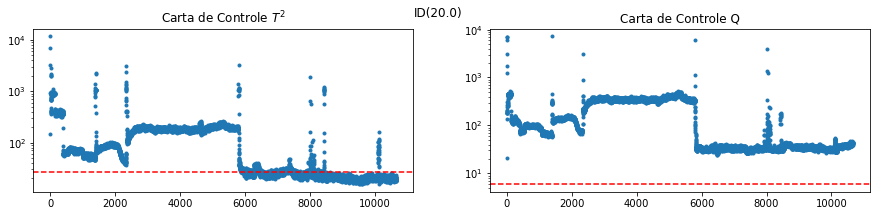

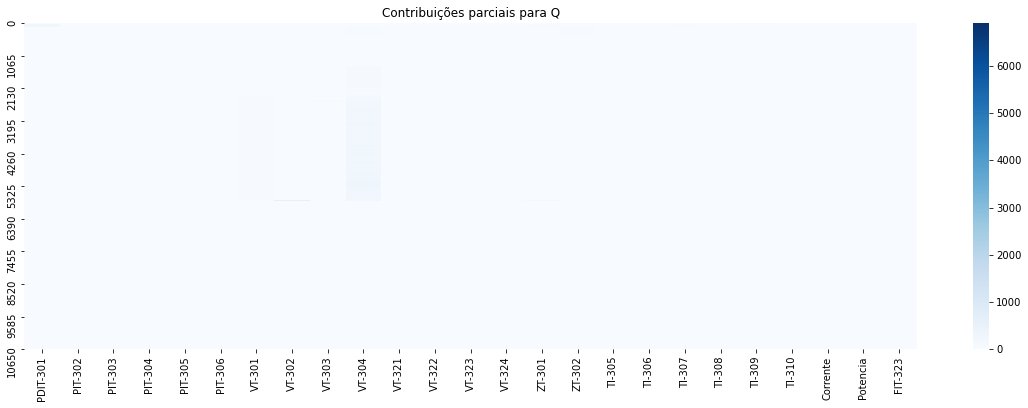


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(24.0)

T2: 0.9053415645016375
Q: 1.0


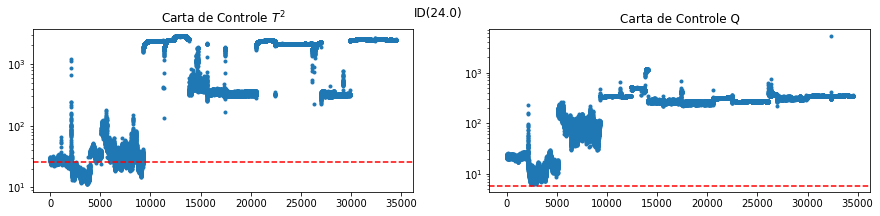

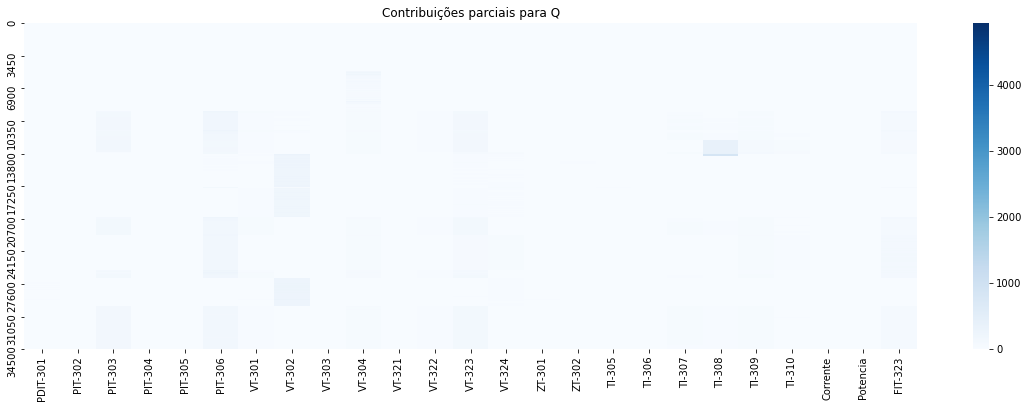


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(25.0)

T2: 0.5334134360532918
Q: 1.0


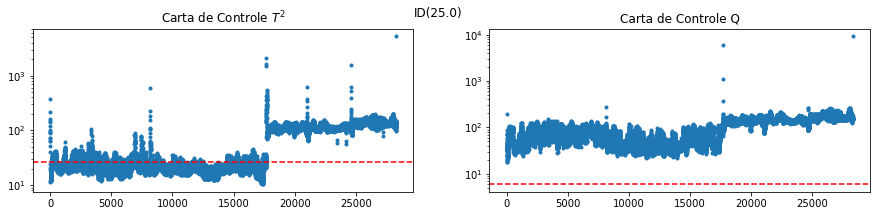

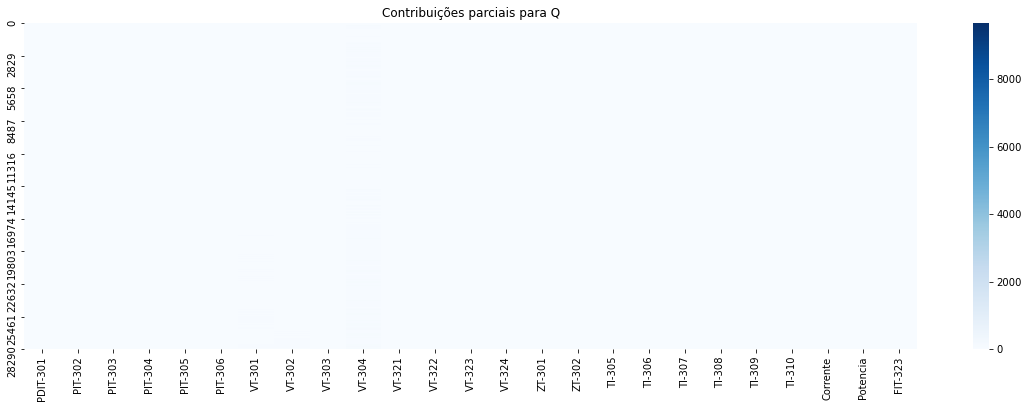


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(27.0)

T2: 1.0
Q: 1.0


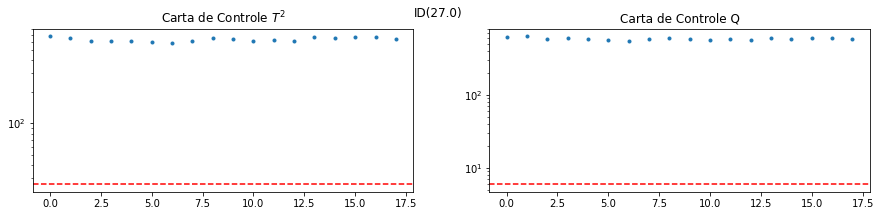

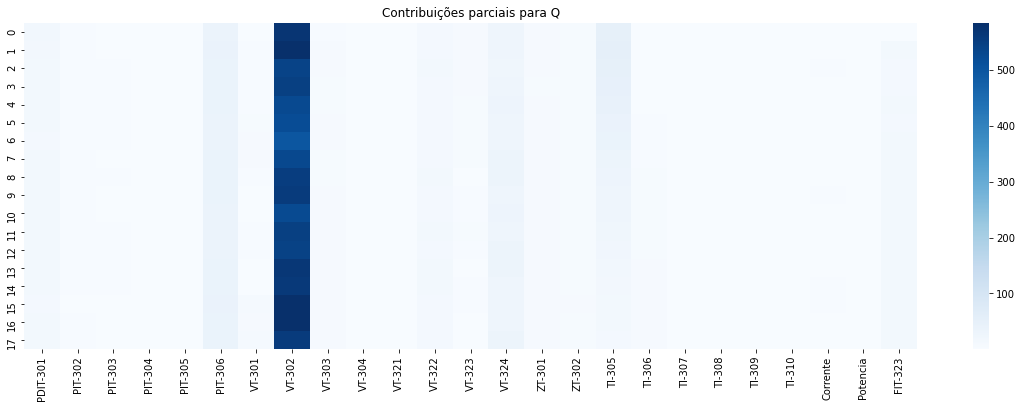

In [16]:
# Aplicação do PCA

fault_id = labeled_data['rotulos_multi'].unique()[1:] 

# Dataframe para armazenar estatísticas calculadas
pca_stats = pd.DataFrame(np.zeros((len(fault_id),3)), columns=['fault', 'T2', 'Q'])

# Dataframe para armazenar o resultado do PCA de cada instância
pca_results_final = pd.DataFrame(columns=['T2', 'Q', 'fault'])

data_to_pca = labeled_data.copy()
data_to_pca.rename(columns={'rotulos_multi': 'STATUS'}, inplace=True)

i=0

for fault in fault_id:
    
    print("\n-------------------------------------------------------------------------------")
    df_test = data_to_pca.query("STATUS == " + str(fault)).copy()
    df_test.drop(['timestamp', 'STATUS', 'rotulos_bin'], 1, inplace=True)
    
    pca.predict(df_test)
    
    print(f'Taxas de detecção de falhas - ID({fault})')
    
    print(f'\nT2: {(pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]}')
    print(f'Q: {(pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]}')
    
    pca_stats['fault'].iloc[i] = fault
    pca_stats['Q'].iloc[i] = (pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]
    pca_stats['T2'].iloc[i] = (pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]
    
    pca_results_parcial = pd.DataFrame(columns=['T2', 'Q'])
    pca_results_parcial['T2'] = pca.T2
    pca_results_parcial['Q'] = pca.Q
    pca_results_parcial['fault'] = fault
    pca_results_final = pca_results_final.append(pca_results_parcial)
    
    i += 1

    pca.plot_control_charts()
    plt.suptitle(f'ID({fault})');

    pca.plot_contributions(columns=df_test.columns)
    plt.show()


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(0)

T2: 0.3322770589602541
Q: 1.0


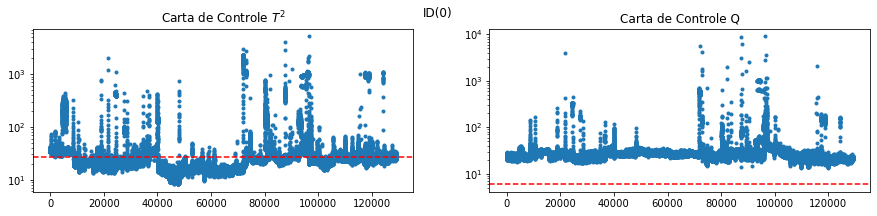

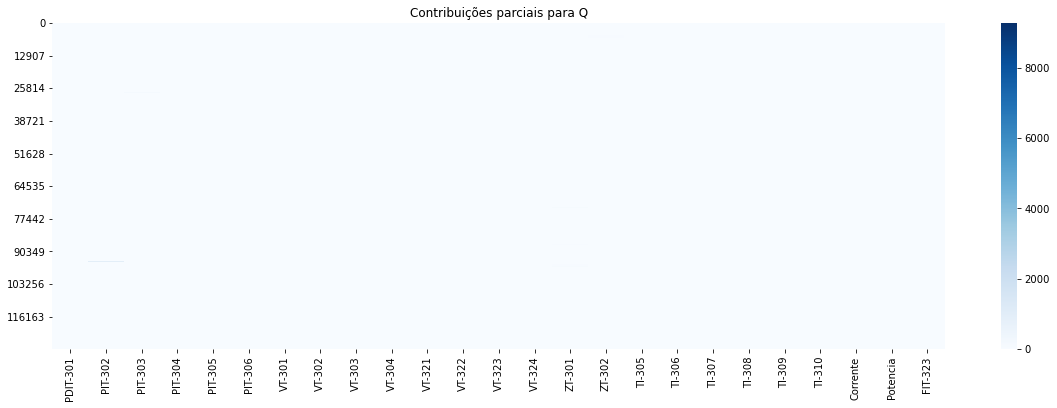

In [17]:
# PCA para a operação normal do teste

# Considera apenas a op. norm. do teste
    # Todos os períodos de operação normal após a falha 17
data_normal_teste = labeled_data[1216608:].query("rotulos_multi == 0").copy() 

print("\n-------------------------------------------------------------------------------")
data_normal_teste.drop(['timestamp', 'rotulos_multi', 'rotulos_bin'], 1, inplace=True)

fault=0

pca.predict(data_normal_teste)

print(f'Taxas de detecção de falhas - ID({fault})')

print(f'\nT2: {(pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]}')
print(f'Q: {(pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]}')

pca_results_parcial = pd.DataFrame(columns=['T2', 'Q'])
pca_results_parcial['T2'] = pca.T2
pca_results_parcial['Q'] = pca.Q    
pca_results_parcial['fault'] = fault
pca_results_final = pca_results_final.append(pca_results_parcial)

pca.plot_control_charts()
plt.suptitle(f'ID({fault})');

pca.plot_contributions(columns=data_normal_teste.columns)
plt.show()

In [18]:
pca_results_final['T2_classific'] = np.where(pca_results_final['T2'] > pca.T2_lim, 1, 0)
pca_results_final['Q_classific'] = np.where(pca_results_final['Q'] > pca.Q_lim, 1, 0)
pca_results_final['fault_bin'] = np.where(pca_results_final['fault'] >= 1, 1, 0)
pca_results_final = pca_results_final.reset_index()

pca_results_final[pca_results_final['fault'] == 17]

,index,T2,Q,fault,T2_classific,Q_classific,fault_bin
574823,0,30.779833,5.202316,17.0,1,0,1
574824,1,31.648250,4.719066,17.0,1,0,1
574825,2,29.659710,5.464591,17.0,1,0,1
574826,3,29.765597,5.511007,17.0,1,0,1
574827,4,30.443619,5.153484,17.0,1,0,1
...,...,...,...,...,...,...,...
577575,2752,39.703775,24.273656,17.0,1,1,1
577576,2753,43.258708,24.209399,17.0,1,1,1
577577,2754,38.720898,23.171643,17.0,1,1,1
577578,2755,33.750347,22.260706,17.0,1,1,1


In [19]:
pca_results_final_teste = pca_results_final[574823:]
pca_results_final_teste

,index,T2,Q,fault,T2_classific,Q_classific,fault_bin
574823,0,30.779833,5.202316,17.0,1,0,1
574824,1,31.648250,4.719066,17.0,1,0,1
574825,2,29.659710,5.464591,17.0,1,0,1
574826,3,29.765597,5.511007,17.0,1,0,1
574827,4,30.443619,5.153484,17.0,1,0,1
...,...,...,...,...,...,...,...
793536,129065,26.544209,22.883211,0.0,1,1,0
793537,129066,28.159669,22.297340,0.0,1,1,0
793538,129067,28.368455,21.681207,0.0,1,1,0
793539,129068,29.554682,21.439858,0.0,1,1,0


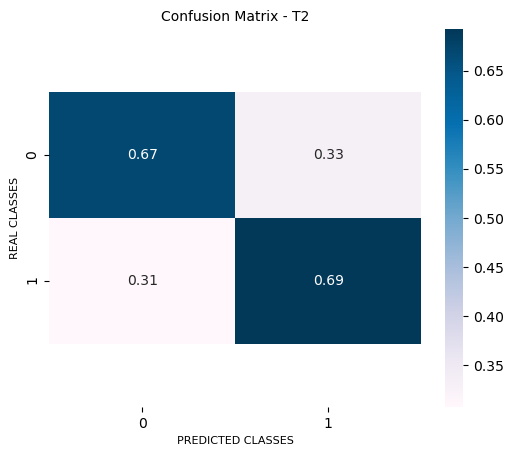


Overall Precision:       59.11%
Overall Recall:          69.16%
Overall F-score(a=1):    63.75%
Overall F-score(a=0.5):  62.12%
Overall F-score(a=2):    65.45%
Overall Specificity:     66.77%
Overall FPR(FAR):        33.23%
Overall Accuracy:        67.75%


In [20]:
# Desempenho por T2

new_status = [0,1]

df_cm = pd.DataFrame(confusion_matrix(pca_results_final_teste['fault_bin'], pca_results_final_teste['T2_classific']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=100)
plt.title("Confusion Matrix - T2", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

tn, fp, fn, tp = confusion_matrix(pca_results_final_teste['fault_bin'], pca_results_final_teste['T2_classific']).ravel()
        
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']

print("\nOverall Precision:       {:.2f}%".format((metricas_df['Precision'].values.item()*100)))
print("Overall Recall:          {:.2f}%".format((metricas_df['Recall'].values.item()*100)))
print("Overall F-score(a=1):    {:.2f}%".format((metricas_df['F-score(a=1)'].values.item()*100)))
print("Overall F-score(a=0.5):  {:.2f}%".format((metricas_df['F-score(a=0.5)'].values.item()*100)))
print("Overall F-score(a=2):    {:.2f}%".format((metricas_df['F-score(a=2)'].values.item()*100)))
print("Overall Specificity:     {:.2f}%".format((metricas_df['Specificity'].values.item()*100)))
print("Overall FPR(FAR):        {:.2f}%".format((metricas_df['FPR(FAR)'].values.item()*100)))
print("Overall Accuracy:        {:.2f}%".format((metricas_df['Accuracy'].values.item()*100)))

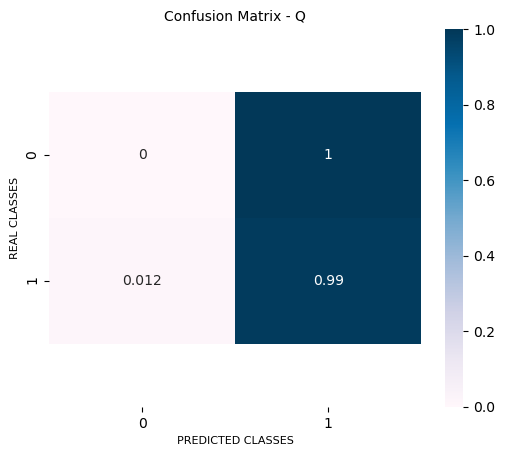


Overall Precision:       40.70%
Overall Recall:          98.80%
Overall F-score(a=1):    57.65%
Overall F-score(a=0.5):  50.62%
Overall F-score(a=2):    66.94%
Overall Specificity:     0.00%
Overall FPR(FAR):        100.00%
Overall Accuracy:        40.50%


In [21]:
# Desempenho por Q

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support , roc_auc_score, auc, precision_score
new_status = [0,1]

df_cm = pd.DataFrame(confusion_matrix(pca_results_final_teste['fault_bin'], pca_results_final_teste['Q_classific']), \
                     index=[i for i in new_status], columns=[i for i in new_status])

# Linha para normalizar os dados
df_cm_norm = round((df_cm.astype('float')/df_cm.sum(axis=1).values.reshape(-1,1)), 3)

# Gráfico da matriz de confusão
plt.figure(figsize=(6,5), dpi=100)
plt.title("Confusion Matrix - Q", fontsize=10)
ax = sn.heatmap(df_cm_norm, annot=True, cmap='PuBu')
ax.set_xlabel("PREDICTED CLASSES", fontsize=8)
ax.set_ylabel("REAL CLASSES", fontsize=8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

tn, fp, fn, tp = confusion_matrix(pca_results_final_teste['fault_bin'], pca_results_final_teste['Q_classific']).ravel()
        
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)
f2_score = 3*recall*precision/((2*precision)+recall)
f05_score = 1.5*recall*precision/((0.5*precision)+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
specificity = tn/(fp+tn)
fpr = fp/(fp+tn)

metricas_df = pd.DataFrame([precision, recall, f1_score, f05_score, f2_score, specificity, accuracy, fpr, tp, \
                            tn, fp, fn]).T
metricas_df.columns = ['Precision', 'Recall', 'F-score(a=1)', 'F-score(a=0.5)', 'F-score(a=2)', \
                       'Specificity', 'Accuracy', 'FPR(FAR)', 'TP', 'TN', 'FP', 'FN']

print("\nOverall Precision:       {:.2f}%".format((metricas_df['Precision'].values.item()*100)))
print("Overall Recall:          {:.2f}%".format((metricas_df['Recall'].values.item()*100)))
print("Overall F-score(a=1):    {:.2f}%".format((metricas_df['F-score(a=1)'].values.item()*100)))
print("Overall F-score(a=0.5):  {:.2f}%".format((metricas_df['F-score(a=0.5)'].values.item()*100)))
print("Overall F-score(a=2):    {:.2f}%".format((metricas_df['F-score(a=2)'].values.item()*100)))
print("Overall Specificity:     {:.2f}%".format((metricas_df['Specificity'].values.item()*100)))
print("Overall FPR(FAR):        {:.2f}%".format((metricas_df['FPR(FAR)'].values.item()*100)))
print("Overall Accuracy:        {:.2f}%".format((metricas_df['Accuracy'].values.item()*100)))

In [22]:
pca_stats

,fault,T2,Q
0,1.0,0.195592,0.165289
1,2.0,0.966241,0.948574
2,6.0,0.270819,0.456386
3,7.0,0.070626,0.012967
4,8.0,0.710585,0.715026
5,9.0,0.004916,0.005118
6,10.0,0.008674,0.028551
7,11.0,0.083557,0.688560
8,17.0,0.864708,0.611172
9,18.0,0.479013,1.000000


### Visualização para novos ajustes no banco

Estes ajustes serão implementados na v1 dos rótulos.

In [ ]:
# Falha 8 
# Basta trocar a data de fechamento para 19/11/2012 - retirada desse retorno do final

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 8]['timestamp'],
         labeled_data[labeled_data['rotulos_multi'] == 8]['VT-322'])

In [ ]:
# Falha 9
# Corte no início e no final

print(labeled_data[labeled_data['rotulos_multi'] == 9].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 9]['timestamp'][4000:-4850],
         labeled_data[labeled_data['rotulos_multi'] == 9]['VT-322'][4000:-4850]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].timestamp.max())

In [ ]:
# Falha 17 
# Basta trocar a data de fechamento para 24/05/2012 - retirada desse retorno do final

print(labeled_data[labeled_data['rotulos_multi'] == 17].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 17]['timestamp'][:-500],
         labeled_data[labeled_data['rotulos_multi'] == 17]['VT-322'][:-500]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].timestamp.max())

In [ ]:
# Falha 18 
# Remoção do final, manutenção apenas dos primeiros 4000 pontos

print(labeled_data[labeled_data['rotulos_multi'] == 18].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 18]['timestamp'][:4000],
         labeled_data[labeled_data['rotulos_multi'] == 18]['VT-304'][:4000]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].timestamp.max())

In [ ]:
# Falha 20

print(labeled_data[labeled_data['rotulos_multi'] == 20].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 20]['timestamp'][:-3000],
         labeled_data[labeled_data['rotulos_multi'] == 20]['VT-304'][:-3000]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].timestamp.max())